# Random Forest - Caso Titanic

En este notebook, utilizaremos Random Forest para entrenar un algoritmo de clasificación que permita establecer un modelo que prediga los sobrevivientes del dataset Titanic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Carga de Datos y Análisis Exploratorio

In [4]:
df = pd.read_csv('titanic.csv')

In [6]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


### Valores perdidos

La cabina no aporta mucho en el análisis, pero la edad es una variable importante para predecir si una persona sobrevivió o no a la trajedia. A continuación, una forma de "visualizar" los valores perdidos.

Haremos una imputación de la edad del pasajero en función del promedio de edad de la clase en la que viajaba.

In [11]:
#edades = round(df.groupby('Pclass').mean()['Age'])
edades = df.groupby('Pclass')['Age'].mean().round()
edades

Pclass
1    38.0
2    30.0
3    25.0
Name: Age, dtype: float64

In [13]:
# creamos una funcion que imputa la edad en caso de estar nula
def imputar_edad(cols):
    edad = cols[0]
    pclass = cols[1]
    if(pd.isnull(edad)):
        if(pclass==1):
            return 38
        if(pclass==2):
            return 30
        if(pclass==3):
            return 25
    else:
        return edad

In [15]:
df['Age'] = df[['Age','Pclass']].apply(imputar_edad, axis=1)

/var/folders/z7/s8_bm31j1vqbws7fljh6p4xw0000gn/T/ipykernel_22938/3628055789.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  edad = cols[0]
/var/folders/z7/s8_bm31j1vqbws7fljh6p4xw0000gn/T/ipykernel_22938/3628055789.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pclass = cols[1]


In [17]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Formulación del modelo

En esta sección seleccionaremos las variables que incorporaremos en la matriz de predictores "X" y en el vector de resultados "y", ya que no todas las columnas son de utilidad.

In [20]:
# Convertir 'Sex' y 'Embarked' a numerico y procesar missings
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

df['Embarked'] = df['Embarked'].fillna('S')
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)

# Definir X e y
X = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare'] + [col for col in df.columns if 'Embarked' in col]]
y = df['Survived']


In [22]:
X

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
0,3,0,22.0,1,0,7.2500,False,True
1,1,1,38.0,1,0,71.2833,False,False
2,3,1,26.0,0,0,7.9250,False,True
3,1,1,35.0,1,0,53.1000,False,True
4,3,0,35.0,0,0,8.0500,False,True
...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,False,True
887,1,1,19.0,0,0,30.0000,False,True
888,3,1,25.0,1,2,23.4500,False,True
889,1,0,26.0,0,0,30.0000,False,False


### Validación Cruzada

In [25]:
from sklearn.model_selection import train_test_split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=0)

### Modelamiento con Árbol de Decisión

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
#from sklearn.impute import SimpleImputer

In [32]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [34]:
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_scaled, y_train)

DecisionTreeClassifier(random_state=42)

In [36]:
# Predicciones y  Evaluación para Decision Tree
y_pred_tree = tree_model.predict(X_test_scaled)
print("Modelo Decision Tree ")
print("Accuracy:", accuracy_score(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_tree))

Modelo Decision Tree 
Accuracy: 0.7932960893854749
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       110
           1       0.79      0.64      0.70        69

    accuracy                           0.79       179
   macro avg       0.79      0.76      0.77       179
weighted avg       0.79      0.79      0.79       179

Matriz de Confusión:
 [[98 12]
 [25 44]]


### Modelamiento con Random Forest

In [39]:
forest_model = RandomForestClassifier(n_estimators=200, random_state=0)
forest_model.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [41]:
# Predicciones y  Evaluación para Random Forest
y_pred_forest = forest_model.predict(X_test_scaled)
print("\nModelo Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_forest))
print(classification_report(y_test, y_pred_forest))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_forest))


Modelo Random Forest
Accuracy: 0.8491620111731844
              precision    recall  f1-score   support

           0       0.85      0.91      0.88       110
           1       0.84      0.75      0.79        69

    accuracy                           0.85       179
   macro avg       0.85      0.83      0.84       179
weighted avg       0.85      0.85      0.85       179

Matriz de Confusión:
 [[100  10]
 [ 17  52]]


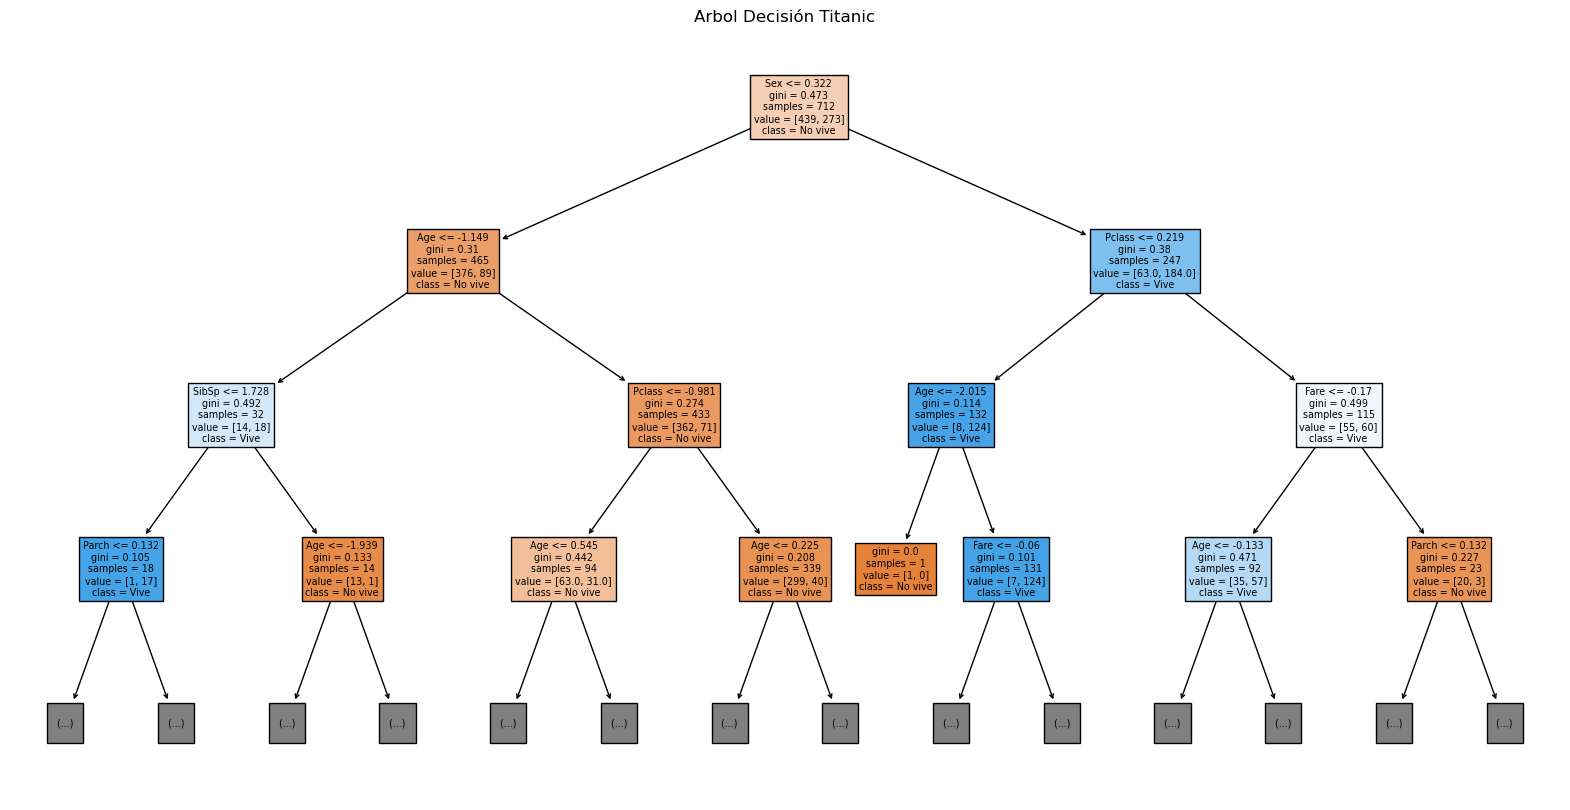

In [43]:
# Graficar Arbol de Decisión

plt.figure(figsize=(20, 10))
plot_tree(tree_model, filled=True, feature_names=X.columns, class_names=['No vive', 'Vive'], max_depth = 3)
plt.title("Arbol Decisión Titanic")
plt.show()

In [45]:
from sklearn.tree import export_graphviz
import graphviz

# Exportar Arbol a dot file string
dot_data = export_graphviz(tree_model, out_file=None, 
                           feature_names=X.columns,  
                           class_names=['No Vive', 'Vive'],  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Usar graphviz para crear gráfico
graph = graphviz.Source(dot_data)
graph.render("titanic_decision_tree")  # Guarda archivo, ej., a PDF o PNG

# Desplegar
graph.view()

'titanic_decision_tree.pdf'

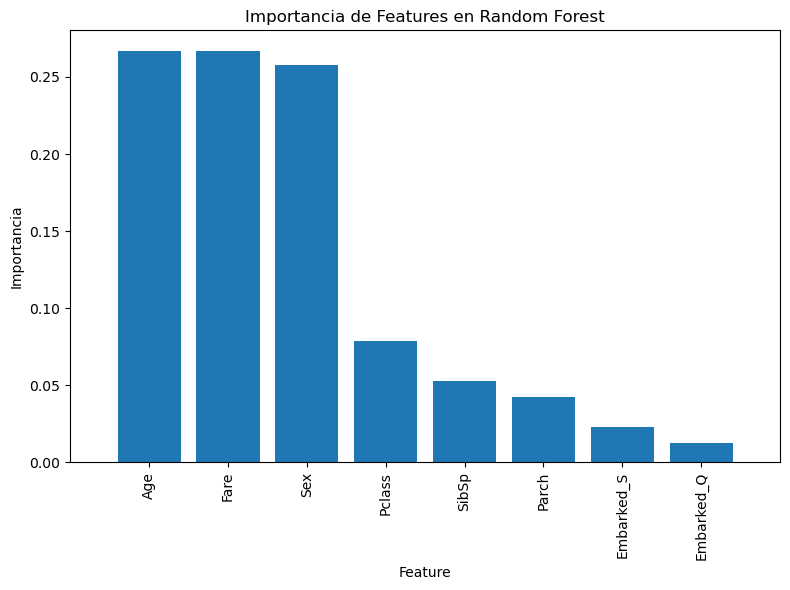

In [47]:
# Para revisar importancias de los Features
importances = forest_model.feature_importances_

# Obtener indices de feature importances
indices = np.argsort(importances)[::-1]

# Nombres de los Features
feature_names = X.columns

# Plot
plt.figure(figsize=(8, 6))
plt.title("Importancia de Features en Random Forest")
plt.bar(range(X_train_scaled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_scaled.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train_scaled.shape[1]])
plt.xlabel("Feature")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

In [49]:
# Generar informes de classificación 
report_tree = classification_report(y_test, y_pred_tree, output_dict=True)
report_forest = classification_report(y_test, y_pred_forest, output_dict=True)

# Convertir a df 
tree_df = pd.DataFrame(report_tree).transpose()
forest_df = pd.DataFrame(report_forest).transpose()

# Combinar reportes 
comparison_df = pd.concat([tree_df, forest_df], axis=1, keys=['Decision Tree', 'Random Forest'])

# Desplegar
comparison_df

Decision Tree                                 Random Forest  \
                 precision    recall  f1-score     support     precision   
0                 0.796748  0.890909  0.841202  110.000000      0.854701   
1                 0.785714  0.637681  0.704000   69.000000      0.838710   
accuracy          0.793296  0.793296  0.793296    0.793296      0.849162   
macro avg         0.791231  0.764295  0.772601  179.000000      0.846705   
weighted avg      0.792495  0.793296  0.788314  179.000000      0.848537   

                                              
                recall  f1-score     support  
0             0.909091  0.881057  110.000000  
1             0.753623  0.793893   69.000000  
accuracy      0.849162  0.849162    0.849162  
macro avg     0.831357  0.837475  179.000000  
weighted avg  0.849162  0.847458  179.000000

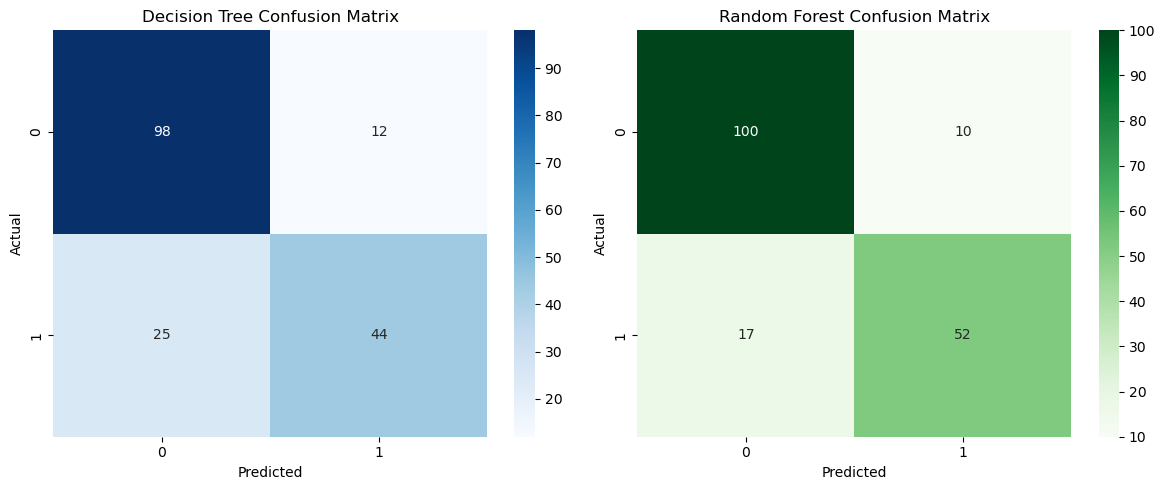

In [51]:
cm_tree = confusion_matrix(y_test, y_pred_tree)
cm_forest = confusion_matrix(y_test, y_pred_forest)

# Set up two subplots side-by-side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for Decision Tree
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title('Decision Tree Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Plot confusion matrix for Random Forest
sns.heatmap(cm_forest, annot=True, fmt='d', cmap='Greens', ax=ax[1])
ax[1].set_title('Random Forest Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

# Tight layout for better spacing
plt.tight_layout()
plt.show()

### Grid Search 

In [54]:
from sklearn.model_selection import GridSearchCV

# Definir los parametos para el grid to search
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at each split
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'bootstrap': [True, False]  # Method for sampling data
}




In [56]:
# Initialize RandomForestClassifier
rf = RandomForestClassifier(random_state=0)

# Set up the grid search with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Extract best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Cross-validation Accuracy: {:.2f}".format(best_score))

# Evaluate the best model on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Print a classification report
print("\nClassification Report for Best Model:\n", classification_report(y_test, y_pred))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimato

/Users/gio/Anaconda/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1080 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
751 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/gio/Anaconda/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/gio/Anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Users/gio/Anaconda/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_param

Best Parameters:  {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-validation Accuracy: 0.83

Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       110
           1       0.88      0.67      0.76        69

    accuracy                           0.84       179
   macro avg       0.85      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



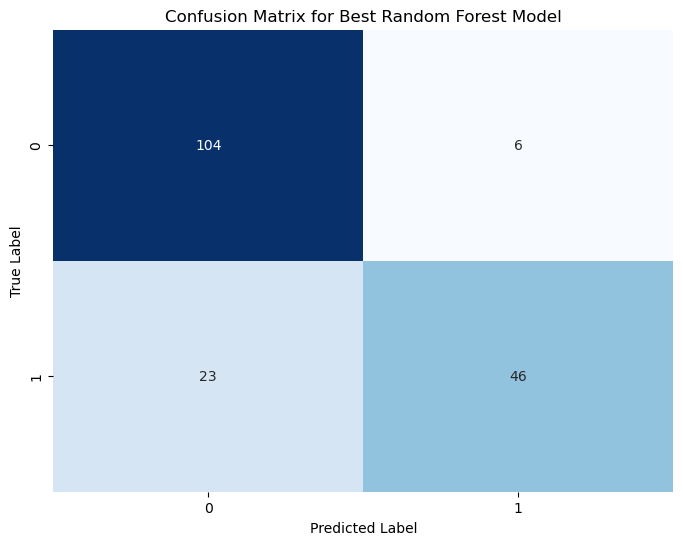


Classification Report for Best Model:
               precision    recall  f1-score   support

           0       0.82      0.95      0.88       110
           1       0.88      0.67      0.76        69

    accuracy                           0.84       179
   macro avg       0.85      0.81      0.82       179
weighted avg       0.84      0.84      0.83       179



In [57]:


# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Best Random Forest Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification report for additional insights
print("\nClassification Report for Best Model:\n", classification_report(y_test, y_pred))

In [60]:

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

# Crea un dataset sintetico 
np.random.seed(0)
X = np.random.rand(100, 3)
# Introducir multicolinealidad haciendo que los features estén correlacionados 
X[:, 1] = X[:, 0] + np.random.normal(0, 0.01, size=(X.shape[0]))
X[:, 2] = X[:, 0] + np.random.normal(0, 0.01, size=(X.shape[0]))
y = 2 * X[:, 0] + 3 * X[:, 1] + 4 * X[:, 2] + np.random.normal(0, 0.1, size=(X.shape[0]))

# Crear un DataFrame para visualización
df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2', 'Feature 3'])
df['Target'] = y

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Fit a standard linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Coeficientes sin regularización
print("Coeficientes de la Regresión Lineal:", lin_reg.coef_)

Coeficientes de la Regresión Lineal: [0.67954013 3.97433151 4.35590077]


In [64]:
# Aplicar Regresión de Ridge
ridge_reg = Ridge(alpha=1.0)  # You can adjust alpha to see its effect
ridge_reg.fit(X_train, y_train)

# Coeficientes con regularización
print("Coeficientes de la Regresión Lineal:", ridge_reg.coef_)

Coeficientes de la Regresión Lineal: [2.85700267 2.86087923 2.88031705]


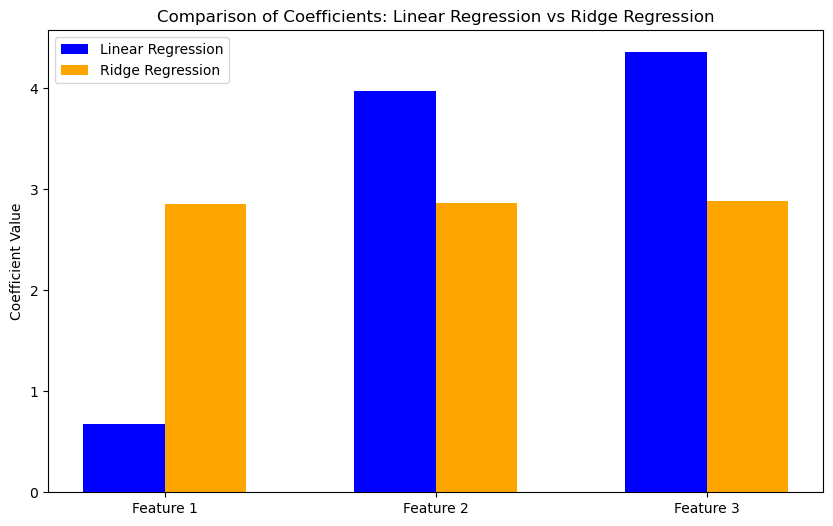

In [68]:
# Plot the coefficients
features = ['Feature 1', 'Feature 2', 'Feature 3']
lin_coefs = lin_reg.coef_
ridge_coefs = ridge_reg.coef_

x = np.arange(len(features))

plt.figure(figsize=(10, 6))
plt.bar(x - 0.15, lin_coefs, width=0.3, label='Linear Regression', color='blue')
plt.bar(x + 0.15, ridge_coefs, width=0.3, label='Ridge Regression', color='orange')
plt.xticks(x, features)
plt.ylabel('Coefficient Value')
plt.title('Comparison of Coefficients: Linear Regression vs Ridge Regression')
plt.legend()
plt.show()

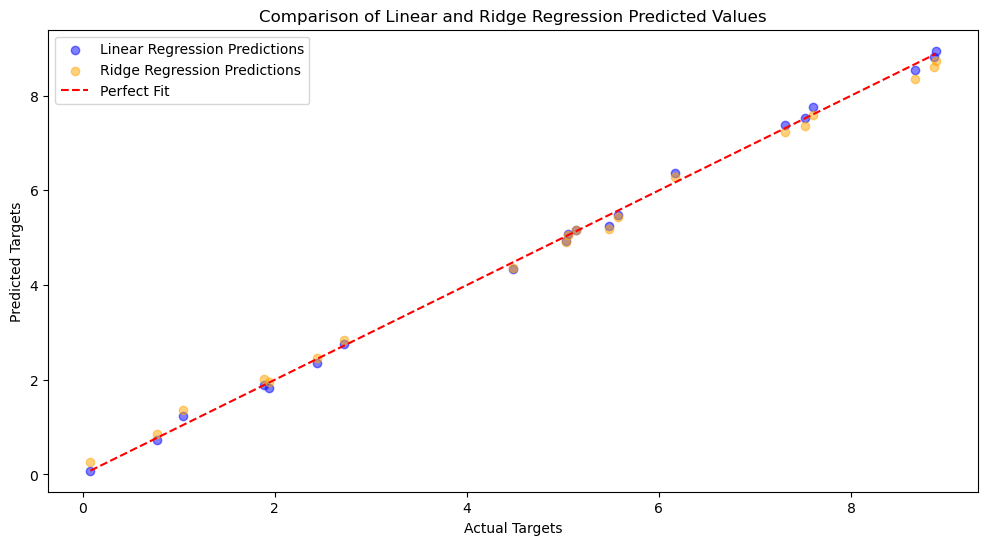

In [70]:
# Predict on the test set
lin_pred = lin_reg.predict(X_test)
ridge_pred = ridge_reg.predict(X_test)

# Plot the results
plt.figure(figsize=(12, 6))

plt.scatter(y_test, lin_pred, color='blue', alpha=0.5, label='Linear Regression Predictions')
plt.scatter(y_test, ridge_pred, color='orange', alpha=0.5, label='Ridge Regression Predictions')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Fit')

plt.xlabel('Actual Targets')
plt.ylabel('Predicted Targets')
plt.title('Comparison of Linear and Ridge Regression Predicted Values')
plt.legend()
plt.show()

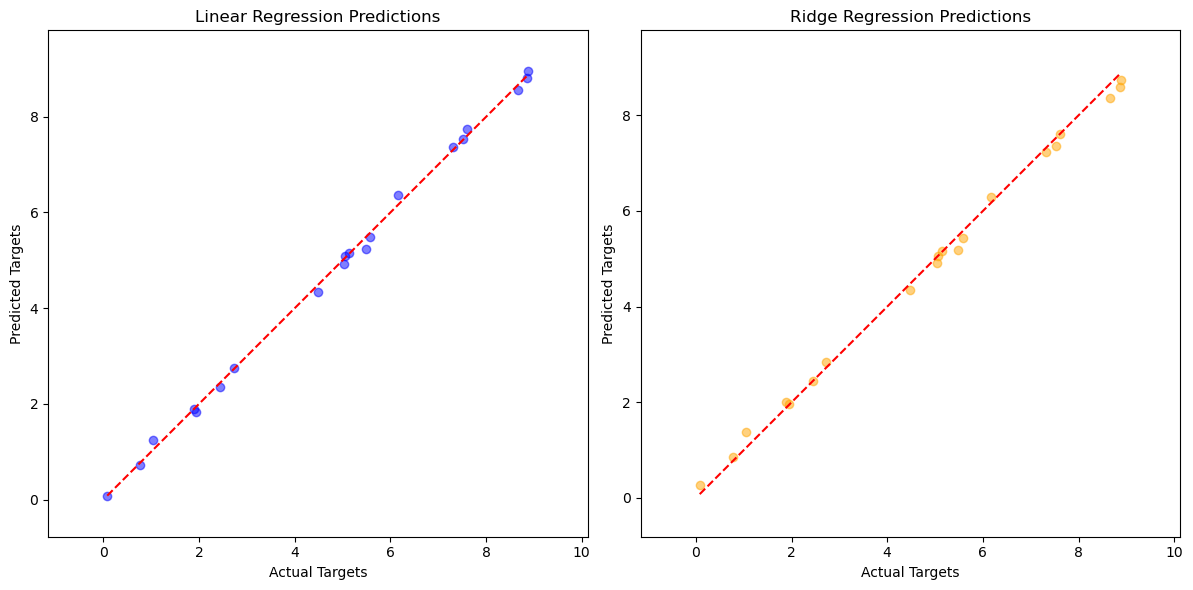

In [428]:
# Predict on the test set
lin_pred = lin_reg.predict(X_test)
ridge_pred = ridge_reg.predict(X_test)

# Plot Linear Regression results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, lin_pred, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Targets')
plt.ylabel('Predicted Targets')
plt.title('Linear Regression Predictions')
plt.axis('equal')

# Plot Ridge Regression results
plt.subplot(1, 2, 2)
plt.scatter(y_test, ridge_pred, color='orange', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Targets')
plt.ylabel('Predicted Targets')
plt.title('Ridge Regression Predictions')
plt.axis('equal')

plt.tight_layout()
plt.show()

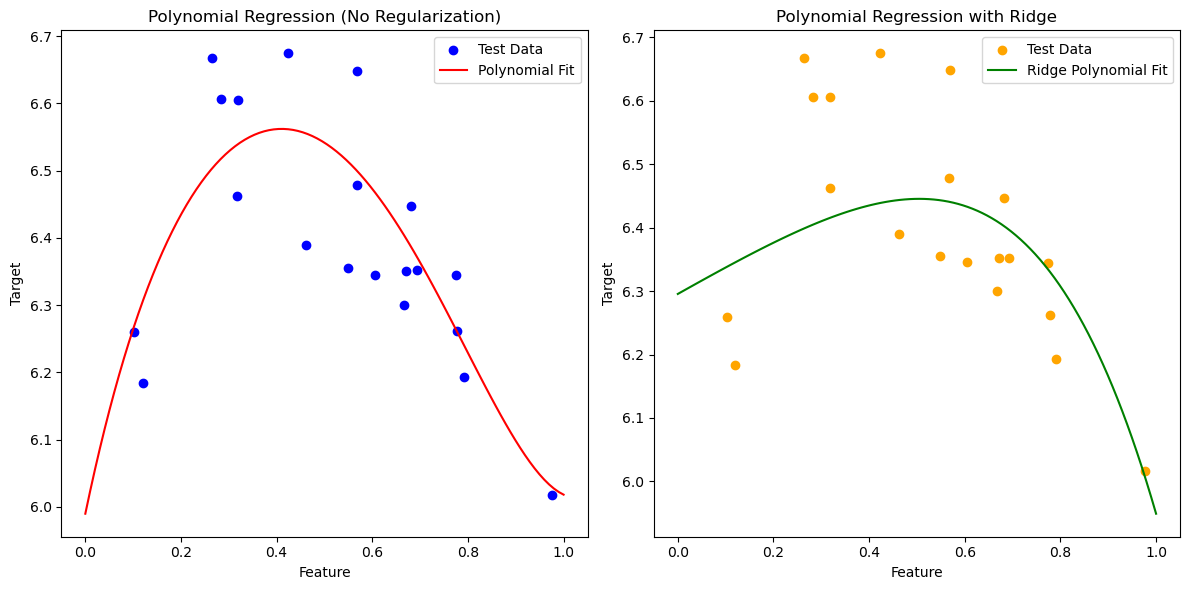

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

# Create a synthetic dataset
np.random.seed(0)
X = np.random.rand(100, 1)  # Single feature for simplicity
y = (2 * X**3 - 5 * X**2 + 3 * X + 6).flatten() + np.random.normal(0, 0.1, X.shape[0])  # Cubic relationship for more complexity

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transform features into higher-degree polynomial features (degree=5)
poly = PolynomialFeatures(degree=5)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit a standard polynomial regression model (no regularization)
lin_reg = LinearRegression()
lin_reg.fit(X_train_poly, y_train)

# Fit a Ridge regression model (regularization)
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train_poly, y_train)

# Predict on the test set
lin_pred = lin_reg.predict(X_test_poly)
ridge_pred = ridge_reg.predict(X_test_poly)

# Generate x values for curve plotting
X_curve = np.linspace(0, 1, 100).reshape(-1, 1)
X_curve_poly = poly.transform(X_curve)
y_curve_lin = lin_reg.predict(X_curve_poly)
y_curve_ridge = ridge_reg.predict(X_curve_poly)

# Plot Polynomial Regression results without regularization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(X_test.flatten(), y_test, color='blue', marker='o', label='Test Data')
plt.plot(X_curve, y_curve_lin, color='red', linestyle='-', label='Polynomial Fit')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Polynomial Regression (No Regularization)')
plt.legend()

# Plot Polynomial Regression results with Ridge regularization
plt.subplot(1, 2, 2)
plt.scatter(X_test.flatten(), y_test, color='orange', marker='o', label='Test Data')
plt.plot(X_curve, y_curve_ridge, color='green', linestyle='-', label='Ridge Polynomial Fit')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Polynomial Regression with Ridge')
plt.legend()

plt.tight_layout()
plt.show()